In [1]:
import os,sys
sys.path.append('../')
import pickle
from DJSCCv2 import *
import torch
from functions import Imageset
from compressai.ops import compute_padding
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import warnings
torch.manual_seed(10)


In [8]:
dev = 'cuda:7'
with open('../savedmodels/model_snrdb_10_bwr_0.095_2024_01_21_14_41_27.pth.tar','rb') as f:
    model0=pickle.load(f)
model = Autoencoder(5,0.095,(3,256,256))
model.load_state_dict(model0.state_dict())
model = model.to(dev)
dset = Imageset('../../compress_lip/Jianhao_datasets/CLIC/',transforms.Resize((256,256)),1,1)
dloader = dataloader.DataLoader(dset,1,True)
model.eval()

Number of feature map:  10


Autoencoder(
  (encoder): Encoder(
    (layers): Sequential(
      (conv1): Conv2d(3, 256, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
      (GDN1): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
      )
      (prelu1): PReLU(num_parameters=256)
      (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (GDN2): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
      )
      (prelu2): PReLU(num_parameters=256)
      (conv3): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (GDN3): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer

In [239]:
# Implement a SU-MISO channel layer
class CHN_SU_MISO(nn.Module):
    def __init__(self, Nt, w, h, P, p_noise):
        super(CHN_SU_MISO, self).__init__()
        p_noise_ = p_noise/2
        stddev = p_noise_**(0.5)
        self.Nt = Nt
        self.w = w
        self.h = h
        self.P = P
        self.stddev = stddev
        if torch.norm(self.w)!=1:
            warnings.warn("Non-unit beamforming vector.")
    def forward(self, x):
        noise = torch.normal(0, self.stddev, size=x.shape).to(x.device)
        amp_gain = (self.P**(0.5)*self.w.T@self.h).item()
        return (amp_gain*x+noise)/amp_gain


In [5]:
# torch.manual_seed(10)
# Nt = 3
# w = F.normalize(torch.randn(Nt,1),dim=(0,1))
# h = F.normalize(torch.randn(Nt,1),dim=(0,1))
# # w = h
# P = 3
# p_noise = 1
# su_miso = CHN_SU_MISO(Nt,w,h,P,p_noise)
# print("beamforming&channel gain: ", (P**(0.5)*w.T@h).item())
# SNR_linear = (P**(0.5)*w.T@h).item()**2/p_noise
# SNR_dB = 10*torch.log10(torch.Tensor([SNR_linear])).item()
# print("SNR_linear: ", SNR_linear)
# print("SNR_dB: ", SNR_dB)

with torch.no_grad():
    for x in dset:
    # x = transforms.PILToTensor()(img)/255
        x=x.unsqueeze(0).to(dev)
        height,width=x.size(2),x.size(3)
        pad,unpad=compute_padding(height,width,min_div=2**6)
        x_padded = F.pad(x,pad,mode='constant',value=0)
        outenc = model.encoder(x_padded)
        # outchn = su_miso(outenc)
        outchn = outenc
        xhat = model.decoder(outchn)
        x_unpad = F.pad(xhat,unpad)
        break

tensor(106338.6719, device='cuda:7')


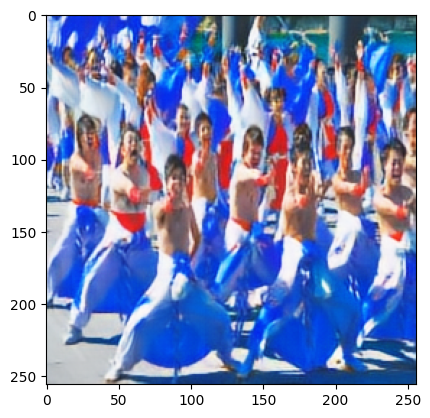

In [6]:
plt.imshow(x_unpad.squeeze().to('cpu').permute(1,2,0))
print(torch.sum(x_unpad))
# tensor(2955533., device='cuda:6')

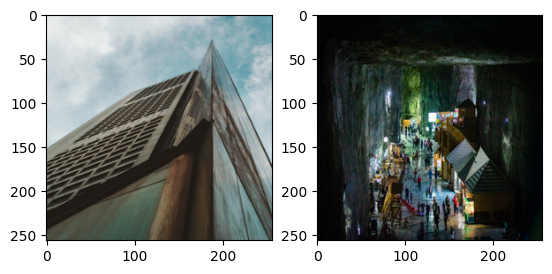

In [6]:
img1 = Image.open('../../compress_lip/Jianhao_datasets/CLIC/oscar-keys-iWNFqEYpmmo-unsplash.png')
img1 = img1.resize((256,256))
plt.subplot(121)
plt.imshow(img1)
img2 = Image.open('../../compress_lip/Jianhao_datasets/CLIC/adrian-moise-0iRqoHHxjQk-unsplash.png')
img2 = img2.resize((256,256))
plt.subplot(122)
plt.imshow(img2)

In [3]:
# Implement a MU-MISO channel layer
class CHN_MU_MISO(nn.Module):
    """
    U: Number of users.
    Nt: Number of transmitter antennas.
    W: Nt x U matrix. Each column is a beamforming vector.
    H: Nt x U matrix. Each column is a channel vector.
    P: N x 1 vector. Each element is a power allocated to a user.
    p_noise: N x 1 vector. Each element is a complex-noise power for a user.
    """
    def __init__(self, U, Nt, W, H, P, p_noise):
        super(CHN_MU_MISO, self).__init__()
        p_noise_ = torch.Tensor(p_noise)/2
        stddev = p_noise_**(0.5)
        self.U = U
        self.Nt = Nt
        self.W = W
        self.H = H
        self.P = P
        self.stddev = stddev
        v = sum(abs(torch.norm(self.W,dim=0)-1))
        if v>1e-5:
            warnings.warn(f"Non-unit beamforming vector: {v}")
    def forward(self, x):
        """
        x: U x Batch x CWH tensor. concatenated input of all users.
        """
        # beamforming vector weighted signals
        # for user 1:
        combined_signal = 0
        for u in range(self.U):
            combined_signal += torch.stack([(self.P[u])**(0.5)*x[u]*self.W[nt,u] for nt in range(self.Nt)])
        # combined_signal: Nt x Batch x CWH
        print("combined_signal: ", combined_signal.shape)
        y = []
        for u in range(self.U):
            # transmit to u-th user
            received_signal = torch.stack([combined_signal[nt]*self.H[nt,u] for nt in range(self.Nt)])
            received_signal = torch.sum(received_signal,dim=0)
            print("received_signal: ", received_signal.shape)
            noise = torch.normal(0, self.stddev[u], size=received_signal.shape).to(received_signal.device)
            received_signal += noise
            amp_gain = (self.P[u])**(0.5)*(self.H[:,u]@self.W[:,u]).item()
            decoded_signal = received_signal/amp_gain
            y.append(decoded_signal)
        y = torch.stack(y)
        return y
Nt = 3
U = 2
W = F.normalize(torch.randn(Nt,U),dim=0)
H = torch.randn(Nt,U)
P = [1,1]
p_noise = [0.1,0.1]
mu_simo = CHN_MU_MISO(U,Nt,W,H,P,p_noise)



In [4]:
# torch.manual_seed(10)
# # W = F.normalize(torch.randn(Nt,U),dim=0)
# # H = torch.randn(Nt,U)
H = torch.Tensor([[1,0.1],[0.3,1]])
W_dict = {
    "ZF":F.normalize(H@torch.inverse(H.T@H),dim=0),
    "OPT":torch.Tensor([[0.9976,-0.2448],[-0.0693,0.9696]])
}
P_dict = {
    "OPT": [0.6846,0.2837],
    "ZF":[0.5,0.5]}
p_noise = [0.3**2,0.15**2]

def sinr_downlink(W_dict,P,H,p_noise):
    U = len(p_noise)
    for mode,W in W_dict.items():
        print("-------------",mode)
        # compute SINR
        sinr = []
        for u in range(U):
            signal_power = P[mode][u]*(W[:,u]@H[:,u])**2
            interference_power = 0
            for u_ in range(U):
                if u_ == u:
                    continue
                interference_power += P[mode][u_]*(W[:,u_]@H[:,u])**2
            print("interference_power: ", interference_power)
            sinr.append(signal_power/(interference_power+p_noise[u]))
        print(sinr)
sinr_downlink(W_dict,P_dict,H,p_noise)

------------- ZF
interference_power:  tensor(4.4409e-16)
interference_power:  tensor(6.9389e-16)
[tensor(5.1755), tensor(19.1825)]
------------- OPT
interference_power:  tensor(0.0006)
interference_power:  tensor(0.0006)
[tensor(7.2097), tensor(10.9537)]


interference_power:  tensor(0.1945)
interference_power:  tensor(0.1886)
SINR:  [tensor(0.4766), tensor(2.2470)]
combined_signal:  torch.Size([2, 10, 64, 64])
received_signal:  torch.Size([10, 64, 64])
received_signal:  torch.Size([10, 64, 64])
outchn:  torch.Size([2, 10, 64, 64])
tensor(102614.8906, device='cuda:7')
tensor(48661.9375, device='cuda:7')


'\nInput image size consistent.\nEvaluate joint data and semantic distortion: bird dataset.\nBird dataset: resize consistent image size.\nSample U resized images from dataset. transform.resize\n'

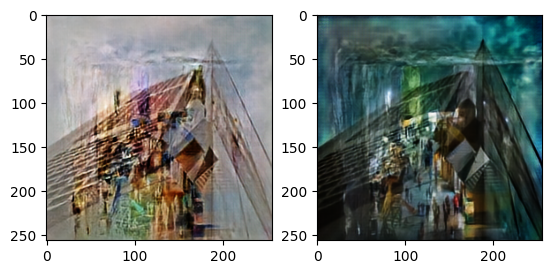

In [10]:

Nt = 2
U = 2
torch.manual_seed(10)
H = torch.randn(Nt,U)
H = torch.Tensor([[1,0.1],[0.3,1]])
# W = F.normalize(H@torch.inverse(H.T@H),dim=0)
W = F.normalize(torch.randn(Nt,U),dim=0)
# W = torch.Tensor([[0.9976,-0.2448],[-0.0693,0.9696]])
P = [1,1]
p_noise = [0.1,0.1]
P = [0.6846,0.2837]
P = [0.5,0.5]
p_noise = [0.3**2,0.15**2]
sinr = []
for u in range(U):
    signal_power = P[u]*(W[:,u]@H[:,u])**2
    interference_power = 0
    for u_ in range(U):
        if u_ == u:
            continue
        interference_power += P[u_]*(W[:,u_]@H[:,u])**2
    print("interference_power: ", interference_power)
    sinr.append(signal_power/(interference_power+p_noise[u]))
print("SINR: ", sinr)

mu_simo = CHN_MU_MISO(U,Nt,W,H,P,p_noise)

with torch.no_grad():
    x1 = transforms.PILToTensor()(img1)/255
    x2 = transforms.PILToTensor()(img2)/255
    x1=x1.unsqueeze(0).to(dev)
    x2=x2.unsqueeze(0).to(dev)
    height1,width1=x1.size(2),x1.size(3)
    height2,width2=x2.size(2),x2.size(3)
    pad1,unpad1=compute_padding(height1,width1,min_div=2**6)
    pad2,unpad2=compute_padding(height2,width2,min_div=2**6)
    x_padded1 = F.pad(x1,pad1,mode='constant',value=0)
    x_padded2 = F.pad(x2,pad2,mode='constant',value=0)
    outenc1 = model.encoder(x_padded1)
    outenc2 = model.encoder(x_padded2)
    # outchn = su_miso(outenc)
    # outchn1 = outenc1
    outchn = mu_simo(torch.stack([outenc1.squeeze(),outenc2.squeeze()]))
    print("outchn: ", outchn.shape)
    outchn1 = outchn[0].unsqueeze(0)
    outchn2 = outchn[1].unsqueeze(0)
    xhat1 = model.decoder(outchn1)
    xhat2 = model.decoder(outchn2)
    x_unpad1 = F.pad(xhat1,unpad1)
    x_unpad2 = F.pad(xhat2,unpad2)
plt.subplot(121)
plt.imshow(x_unpad1.squeeze().to('cpu').permute(1,2,0))
print(torch.sum(x_unpad1))
plt.subplot(122)
plt.imshow(x_unpad2.squeeze().to('cpu').permute(1,2,0))
print(torch.sum(x_unpad2))
"""
Input image size consistent.
Evaluate joint data and semantic distortion: bird dataset.
Bird dataset: resize consistent image size.
Sample U resized images from dataset. transform.resize
"""

In [28]:
Nt = 2
U = 2
torch.manual_seed(10)
H = torch.randn(Nt,U)
H = torch.Tensor([[1,0.1],[0.3,1]])
W = F.normalize(H@torch.inverse(H.T@H),dim=0)
# W = F.normalize(H,dim=0)
# W = torch.Tensor([[0.9976,-0.2448],[-0.0693,0.9696]])
P = [1,1]
p_noise = [0.1,0.1]
P = [0.6846,0.2837]
P = [0.5,0.5]
p_noise = [0.3**2,0.15**2]
sinr = []
for u in range(U):
    signal_power = P[u]*(W[:,u]@H[:,u])**2
    interference_power = 0
    for u_ in range(U):
        if u_ == u:
            continue
        interference_power += P[u_]*(W[:,u_]@H[:,u])**2
    print("interference_power: ", interference_power)
    sinr.append(signal_power/(interference_power+p_noise[u]))
print("SINR: ", sinr)
mu_simo = CHN_MU_MISO(U,Nt,W,H,P,p_noise)

with torch.no_grad():
    # load U images from dataset
    u = 0
    for x in dset:

        continue

[1, 2]

In [5]:
snr_db = 10
snr_linear = 10**(snr_db/10)
sig_power = 2 # signal power is 2 since both the real and imaginary part have power 1
cplx_noise_power = sig_power/snr_linear
real_noise_power = cplx_noise_power/2
real_noise_stddev = real_noise_power**0.5
print(real_noise_stddev)

0.31622776601683794


In [1]:
import pickle
with open('../evalresults/CLIC_evalres_2024_01_22_16_05_31.pkl','rb') as f:
    res = pickle.load(f)
res

{'test_snrdbs': [2, 5, 7, 10, 12],
 'channel': 1,
 'dataset': 'CLIC',
 'model_snrdb_10_bwr_0.020_2024_01_21_16_36_54.pth.tar': defaultdict(list,
             {'mse': [0.013192532118409872,
               0.005234904276827971,
               0.002875420769366125,
               0.0017433851996126275,
               0.0015413382595094542],
              'psnr': [18.79671839820447,
               22.810912552316495,
               25.412985946463817,
               27.586066452574602,
               28.12102041283171],
              'ssim': [0.6296097636222839,
               0.7933590610822042,
               0.8864264686902364,
               0.9416781465212504,
               0.9478766918182373]}),
 'model_snrdb_10_bwr_0.045_2024_01_21_16_43_30.pth.tar': defaultdict(list,
             {'mse': [0.006681958679109812,
               0.0022389166988432407,
               0.0012438258660646777,
               0.0007743586029391736,
               0.0006785207466843227],
              'psnr'